In [ ]:
pip install networkx==2.3

In [ ]:
!pip install stellargraph

In [ ]:
!pip install linkpred

In [1]:
!pip install stellargraph

In [2]:
import pandas as pd
import numpy as np
import linkpred
import networkx as nx
import multiprocessing
import matplotlib.pyplot as plt

from stellargraph import StellarGraph
from stellargraph.data import EdgeSplitter
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics 
from math import isclose
from sklearn.decomposition import PCA
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

%matplotlib inline

In [3]:
df= pd.read_csv("weight.csv",index_col=0)

In [4]:
  def read_net_w(filename):
    g = nx.Graph()
    with open(filename) as f:
        f.readline()
        for l in f:
            l = l.split(",")
            g.add_edge(l[1], l[2], weight=int(float(l[3].rstrip('\n'))))
    return g


In [5]:
def sample_data(g): 
    degree_calc = {node: val for (node, val) in g.degree()}
    degree = dict(sorted(degree_calc.items(), key=lambda item: item[1], reverse = True))
    sample = []
    for k, v in degree.items():
        if(v >=  20):
            sample.append(k)   
    sample_data = g.subgraph(sample)
    return sample_data

In [6]:
column_names = df.columns

# Stampare i nomi delle colonne
print("Nomi delle colonne nel DataFrame:")
for column in column_names:
    print(column)

Nomi delle colonne nel DataFrame:
Source
Target
Weight


In [7]:
df.shape
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 55847 entries, 0 to 403446
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Source  55847 non-null  object
 1   Target  55847 non-null  object
 2   Weight  55847 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


,Source,Target,Weight
0,HENDERSON BRIAN LESLIE,CUI YAN,28
1,HENDERSON BRIAN LESLIE,DORRIETY DANIEL JAMES,28
2,HENDERSON BRIAN LESLIE,SHUBERT GARY CHARLES,12
3,HENDERSON BRIAN LESLIE,COOK PAUL ALBERT,28
4,CUI YAN,DORRIETY DANIEL JAMES,54
5,CUI YAN,SHUBERT GARY CHARLES,12
6,CUI YAN,COOK PAUL ALBERT,26
7,DORRIETY DANIEL JAMES,SHUBERT GARY CHARLES,12
8,DORRIETY DANIEL JAMES,COOK PAUL ALBERT,26
9,SHUBERT GARY CHARLES,COOK PAUL ALBERT,12


In [8]:
def read_net_w(csv_file):
    g = nx.Graph()

    try:
        # Leggi il file CSV utilizzando pandas
        df = pd.read_csv(csv_file)

        # Aggiungi nodi al grafo
        for node in df['Source']:
            g.add_node(node)

        # Aggiungi archi con attributo di peso
        for _, row in df.iterrows():
            try:
                weight = float(row['Weight'])
            except ValueError:
                # Gestisci l'errore di conversione e assegna un valore predefinito (o None)
                weight = None

            g.add_edge(row['Source'], row['Target'], weight=weight)

    except pd.errors.EmptyDataError:
        # Gestisci il caso in cui il file CSV sia vuoto
        pass
    except FileNotFoundError:
        # Gestisci il caso in cui il file CSV non esista
        pass

    return g

# Usa la funzione per leggere il grafo dal file CSV
g = read_net_w("weight.csv")


In [9]:
Gcc = sorted(nx.connected_components(g), key=len, reverse=True)
g.remove_nodes_from([n for n in g if n not in set(Gcc[0])])

In [10]:
g.remove_edges_from(list(nx.selfloop_edges(g)))

In [11]:
g_small = sample_data(g)

In [12]:
stellar_g = StellarGraph.from_networkx(g_small)

In [13]:
num_nodes = len(g_small.nodes())
num_edges = len(g_small.edges())
print(f"Numero di nodi: {num_nodes}")
print(f"Numero di archi: {num_edges}")

connected_components = list(nx.connected_components(g_small))
print(f"Componenti connesse: {connected_components}")

Numero di nodi: 858
Numero di archi: 3996
Componenti connesse: [{'MORI MUTSUHIRO', 'DORIS BRUCE B', 'ORIKASA TSUYOSHI', 'YAMAMOTO HAJIME', 'FUJIOKA YASUSHI', 'LJUNG RICKARD', 'KAWADE HISAAKI', 'OKUYAMA TOSHIAKI', 'TERAI HARUHIKO', 'KURABAYASHI YUTAKA', 'TAJIMA FUMIO', 'YANG KYEONG-CHEOL', 'KANAI MASAHIRO', 'OGAWA YOSHIHIRO', 'OWASHI HITOAKI', 'NOBUE TOMOTAKA', 'YEO JEONGHO', 'ZHENG XIAOQING', 'YONEMITSU JUN', 'TANEYA YOICHI', 'OTSUKA NAOJI', 'SUZUKI HIROSHI', 'VAN DER VELDE HIMKE', 'KENMOKU TAKASHI', 'KAWASAKI OSAMU', 'MARTIN BRIAN ALEXANDER', 'NOWAK EDWARD J', 'TOBIN JAMES ROBERT', 'YOSHIDA ISAMU', 'BEDELL STEPHEN W', 'LEE KOOK-HEUI', 'KISHORE KUNA VENKAT SATYA RAMA', 'KANG HYUN-JEONG', 'YAMAMOTO MASAYUKI', 'TAKAHASHI WATARU', 'HORAK DAVID V', 'YANG HAI', 'KASAMOTO MASAMI', 'ARAI TAKAO', 'KASAHARA SHUNICHI', 'MATSUDA HIROSHI', 'SATO HIROSHI', 'TAKAHASHI KOJI', 'HASZ WAYNE CHARLES', 'NAM YOUNG-HAN', 'MYERS GEOFFREY DAVID', 'MASUDA KAZUAKI', 'JOO PAN-YUH', 'NIWA TAKASHI', 'SETLUR ANANT 

### Unsupervised Link Prediction

In [14]:
cn = linkpred.predictors.CommonNeighbours(g_small, excluded=g_small.edges()) # We aim to predict only new links, thus we exclude existing ones
cn_results = cn.predict()

top = cn_results.top(20)
for edge, score in top.items():
    print(edge, score)

IZUMIDA MASAAKI - ABE TSUTOMU 24.0
OGATA MASATSUGU - ANJO ICHIRO 20.0
MURAKAMI GEN - ANJO ICHIRO 20.0
EGUCHI SYUUJI - ANJO ICHIRO 20.0
SAIKAWA HIDEO - GOTO AKIRA 19.0
VAN LIESHOUT GERT-JAN - VAN LIESHOUT GERT JAN 18.0
SAITO AKIO - ISHINAGA HIROYUKI 18.0
ISHINAGA HIROYUKI - HATTORI YOSHIFUMI 18.0
TANAKA SHIGEAKI - ABE TSUTOMU 17.0
SUGIMOTO HITOSHI - KUWABARA NOBUYUKI 17.0
SUGAMA SADAYUKI - MASUDA KAZUAKI 17.0
MORIYAMA JIRO - MATSUBARA MIYUKI 17.0
MAEOKA KUNIHIKO - ISHINAGA HIROYUKI 17.0
KAWAI JUN - GOTO AKIRA 17.0
WATANABE TAKASHI - KIMURA MAKIKO 16.0
WATANABE TAKASHI - ABE TSUTOMU 16.0
OHBA TAKASHI - KUWABARA NOBUYUKI 16.0
NAGOSHI SHIGEYASU - KUWABARA NOBUYUKI 16.0
MATSUBARA MIYUKI - KUWABARA NOBUYUKI 16.0
KUWABARA NOBUYUKI - KAWAI JUN 16.0


In [15]:
jc = linkpred.predictors.Jaccard(g_small, excluded=g_small.edges())
jc_results = jc.predict()

top = jc_results.top(20)
for edge, score in top.items():
    print(edge, score)

YAMADA HIROYUKI - MOROOKA YASUO 1.0
TOMIZAWA TAKESHI - KONDO SHIGEO 1.0
LANG STEFFEN - DANOV VLADIMIR 1.0
SHIMIZU ISAMU - FUJIOKA YASUSHI 0.8
OGATA MASATSUGU - ANJO ICHIRO 0.8
MURAKAMI GEN - ANJO ICHIRO 0.8
EGUCHI SYUUJI - ANJO ICHIRO 0.8
SAITOH AKIHITO - IWAWAKI HIRONOBU 0.7777777777777778
TOMOSADA MASAHIRO - KANEKO SATOSHI 0.75
SASAKI YOSHIKI - KAWAMURA HIROYUKI 0.75
SEKI SATOSHI - MARU AKIKO 0.7272727272727273
YAGASAKI YOICHI - HATTORI SHINOBU 0.7142857142857143
LEE HYUN-WOO - LEE HYEON-WOO 0.7142857142857143
YEO JEONGHO - JI HYOUNGJU 0.6875
PARK SUNGJIN - JI HYOUNGJU 0.6875
YAMAMOTO KATSUHIKO - UEDA SHIGEKI 0.6666666666666666
VAN LIESHOUT GERT-JAN - VAN LIESHOUT GERT JAN 0.6666666666666666
TSUDA SHINICHIRO - MORIOKA YUICHI 0.6666666666666666
IMAMURA TAKESHI - IKEDA TAKESHI 0.6666666666666666
MITRAN MARCEL - BRADBURY JONATHAN D 0.6428571428571429


In [16]:
aa = linkpred.predictors.AdamicAdar(g_small, excluded=g_small.edges())
aa_results = aa.predict()

top = aa_results.top(20)
for edge, score in top.items():
    print(edge, score)

VAN LIESHOUT GERT-JAN - VAN LIESHOUT GERT JAN 7.106178706085244
IZUMIDA MASAAKI - ABE TSUTOMU 6.9543526580354404
OGATA MASATSUGU - ANJO ICHIRO 6.279176993558451
MURAKAMI GEN - ANJO ICHIRO 6.279176993558451
EGUCHI SYUUJI - ANJO ICHIRO 6.279176993558451
SAIKAWA HIDEO - GOTO AKIRA 5.4909178703256245
SAITO AKIO - ISHINAGA HIROYUKI 5.253280321815669
ISHINAGA HIROYUKI - HATTORI YOSHIFUMI 5.187424024289093
MORIYAMA JIRO - MATSUBARA MIYUKI 5.088829126723338
SUGAMA SADAYUKI - MASUDA KAZUAKI 5.0846371966678925
SUGIMOTO HITOSHI - KUWABARA NOBUYUKI 5.019370637739384
TANAKA SHIGEAKI - ABE TSUTOMU 4.914827790992371
MAEOKA KUNIHIKO - ISHINAGA HIROYUKI 4.8840109487468135
KAWAI JUN - GOTO AKIRA 4.847624544468381
NAGOSHI SHIGEYASU - KUWABARA NOBUYUKI 4.767499988987685
OHBA TAKASHI - KUWABARA NOBUYUKI 4.658080634006153
KASHINO TOSHIO - FUKUDA TSUGUHIRO 4.614153492073483
FUKUDA TSUGUHIRO - ARASHIMA TERUO 4.614153492073483
WATANABE TAKASHI - ABE TSUTOMU 4.590444524250611
WATANABE TAKASHI - KIMURA MAKIKO 4.

In [17]:
simrank = linkpred.predictors.SimRank(g_small, excluded=g_small.edges())
simrank_results = simrank.predict(c=0.5)

top = simrank_results.top(20)
for edge, score in top.items():
    print(edge, score)

YAMADA HIROYUKI - MOROOKA YASUO 0.5000000793243663
LANG STEFFEN - DANOV VLADIMIR 0.500000047151806
TOMIZAWA TAKESHI - KONDO SHIGEO 0.5000000335675253
YONEKUBO HIROAKI - FUJISHITA KAZUO 0.40272445967398673
TAKAHASHI KATSUHIRO - MORIWAKI YOSHIO 0.39542747186887456
DELVAUX JOHN MCCONNELL - BURDGICK STEVEN SEBASTIAN 0.34743165763851064
WATANABE TSUTOMU - TANAKA KENJI 0.3459021355366753
MIYABE SHIGEO - AOKI MASAKAZU 0.33563918117185726
UCHIDA MASASHI - TANAKA KENJI 0.3279433277129627
TSUCHIYA KENJI - KUROSAWA YUKIO 0.310534566077405
SUZUKI TAKASHI - HONDA KAZUYOSHI 0.3015286113810544
TOYOGUCHI YOSHINORI - TAGUCHI NOBUYOSHI 0.2896283146986746
SHIRAI TAIZO - SHIMA HISATO 0.2876163749671427
NOWAK EDWARD J - KIM JEEHWAN 0.2763651111971916
MATSUDA SHINPEI - AZUHATA SHIGERU 0.2741747981960447
TANAKA KENJI - NAGANO TAKAHIRO 0.27000964913339986
TANI ATSUSHI - OGAWA YOSHIHIRO 0.2605482370701328
SHIMA HISATO - KATAYAMA AKIHIRO 0.2572758600021842
FANG BIAO - DINC OSMAN SAIM 0.2567134070727951
NAKANE S

In [18]:
import networkx as nx
import numpy as np

# Crea il tuo grafo g_small come preferisci
# g_small = ...

# Calcola la matrice di adiacenza del grafo
adj_matrix = nx.adjacency_matrix(g_small)

# Definisci il parametro di attenuazione di Katz
alpha = 0.1  # Puoi regolare il valore di alpha a tuo piacimento

# Calcola la matrice di Katz usando la formula (I - alpha * A)^(-1) - I
num_nodes = g_small.number_of_nodes()
identity_matrix = np.identity(num_nodes)
katz_matrix = np.linalg.inv(identity_matrix - alpha * adj_matrix) - identity_matrix

# Estrai le previsioni di Katz
kz_results = {}
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        edge = (i, j)
        score = katz_matrix[i, j]
        kz_results[edge] = score

# Ordina e stampa i risultati migliori
sorted_results = sorted(kz_results.items(), key=lambda x: x[1], reverse=True)
top = sorted_results[:20]
for edge, score in top:
    print(edge, score)


(117, 536) 11.330978210601021
(92, 117) 10.375781569028836
(238, 803) 6.500744400652173
(117, 599) 6.047732259472766
(8, 117) 4.7091094253993155
(117, 844) 3.6389501523046155
(92, 536) 3.3326406501767702
(117, 126) 3.1525569616942075
(117, 752) 2.954133023583332
(117, 576) 2.326050869027988
(117, 238) 2.302315427555474
(117, 803) 2.2844685979787434
(117, 572) 2.1021017021552133
(117, 682) 2.0923186748073688
(619, 688) 2.022471448345452
(117, 285) 1.9789962626037876
(117, 476) 1.950748586458773
(162, 570) 1.8968341227115584
(117, 800) 1.8936701982408515
(117, 667) 1.8241095824485438


In [19]:
kz = linkpred.predictors.Katz(g_small, excluded=g_small.edges())
kz_results = kz.predict()

top = kz_results.top(20)
for edge, score in top.items():
    print(edge, score)

AttributeError: module 'networkx' has no attribute 'to_scipy_sparse_matrix'

In [21]:
simrank = linkpred.predictors.SimRank(g_small, excluded=g_small.edges())
simrank_results = simrank.predict(c=0.5)

top = simrank_results.top(20)
for edge, score in top.items():
    print(edge, score)

YAMADA HIROYUKI - MOROOKA YASUO 0.5000000793243663
LANG STEFFEN - DANOV VLADIMIR 0.500000047151806
TOMIZAWA TAKESHI - KONDO SHIGEO 0.5000000335675253
YONEKUBO HIROAKI - FUJISHITA KAZUO 0.40272445967398673
TAKAHASHI KATSUHIRO - MORIWAKI YOSHIO 0.39542747186887456
DELVAUX JOHN MCCONNELL - BURDGICK STEVEN SEBASTIAN 0.34743165763851064
WATANABE TSUTOMU - TANAKA KENJI 0.3459021355366753
MIYABE SHIGEO - AOKI MASAKAZU 0.33563918117185726
UCHIDA MASASHI - TANAKA KENJI 0.3279433277129627
TSUCHIYA KENJI - KUROSAWA YUKIO 0.310534566077405
SUZUKI TAKASHI - HONDA KAZUYOSHI 0.3015286113810544
TOYOGUCHI YOSHINORI - TAGUCHI NOBUYOSHI 0.2896283146986746
SHIRAI TAIZO - SHIMA HISATO 0.2876163749671427
NOWAK EDWARD J - KIM JEEHWAN 0.2763651111971916
MATSUDA SHINPEI - AZUHATA SHIGERU 0.2741747981960447
TANAKA KENJI - NAGANO TAKAHIRO 0.27000964913339986
TANI ATSUSHI - OGAWA YOSHIHIRO 0.2605482370701328
SHIMA HISATO - KATAYAMA AKIHIRO 0.2572758600021842
FANG BIAO - DINC OSMAN SAIM 0.2567134070727951
NAKANE S

In [22]:
rnd = linkpred.predictors.Random(g_small, excluded=g_small.edges())
rnd_results = rnd.predict()

top = simrank_results.top(5)
for edge, score in top.items():
    print(edge, score)

YAMADA HIROYUKI - MOROOKA YASUO 0.5000000793243663
LANG STEFFEN - DANOV VLADIMIR 0.500000047151806
TOMIZAWA TAKESHI - KONDO SHIGEO 0.5000000335675253
YONEKUBO HIROAKI - FUJISHITA KAZUO 0.40272445967398673
TAKAHASHI KATSUHIRO - MORIWAKI YOSHIO 0.39542747186887456


### Evaluation (unsupervised)

In [23]:
import itertools
from linkpred.evaluation import Pair

In [24]:
import random

In [25]:
H = g_small.copy()

# Create test network
test = H.subgraph(random.sample(g_small.nodes(), 129))
print("Test nodes: ", len(test.nodes()))
print("Test edges: ", len(test.edges()))

# Exclude test network from learning phase
training = H.copy()
training.remove_edges_from(test.edges())

print("\nTraining: ", len(training.nodes()))
print("Training: ", len(training.edges()))

# Node set
nodes = list(H.nodes())
nodes.extend(list(test.nodes()))

Test nodes:  129
Test edges:  102

Training:  858
Training:  3894


C:\Users\Alma\AppData\Local\Temp\ipykernel_4772\2958603682.py:4: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  test = H.subgraph(random.sample(g_small.nodes(), 129))


In [26]:
# Compute the test set and the universe set
test = [Pair(i) for i in test.edges()]
universe = set([Pair(i) for i in itertools.product(nodes, nodes) if i[0]!=i[1]])

In [27]:
len(universe)

367653

In [28]:
cn = linkpred.predictors.CommonNeighbours(training, excluded=training.edges())
cn_results = cn.predict()

In [29]:
jc = linkpred.predictors.Jaccard(training, excluded=training.edges())
jc_results = jc.predict()

In [30]:
aa = linkpred.predictors.AdamicAdar(training, excluded=training.edges())
aa_results = aa.predict()

In [31]:
simrank = linkpred.predictors.SimRank(training, excluded=training.edges())
simrank_results = simrank.predict()

In [32]:
random = linkpred.predictors.Random(training, excluded=training.edges())
rnd_results = random.predict()

In [33]:
cn_evaluation = linkpred.evaluation.EvaluationSheet(cn_results, test, universe)

In [34]:
simrank_evaluation = linkpred.evaluation.EvaluationSheet(simrank_results, test, universe)

In [35]:
jc_evaluation = linkpred.evaluation.EvaluationSheet(jc_results, test, universe)

In [36]:
aa_evaluation = linkpred.evaluation.EvaluationSheet(aa_results, test, universe)

In [62]:
rnd_evaluation = linkpred.evaluation.EvaluationSheet(rnd_results, test, universe)

In [38]:
def print_res(res):
    res=sorted(res,key=lambda x: x[1],reverse=True)
    for i in res[:10]:
        print(i)

In [60]:
print_res(aa_results)
print("")
print("")
print("")
print_res(cn_results)
print("")
print("")
print("")
print_res(jc_results)
print("")
print("")
print("")
print_res(kz_results)
print("")
print("")
print("")
print_res(simrank_results)
print("")
print("")
print("")
print_res(rnd_results)

ZIMINSKY WILLY STEVE - ZHANG HUA
ZHANG JIANZHONG - YUN SUNG-RYUL
ZHANG JIANZHONG - YOON SOON-YOUNG
YUN SUNG-RYUL - YOON SOON-YOUNG
YOSHIDA ISAMU - YOKONO ATARU
YOKOYAMA TAKASHI - YOKONO ATARU
YUN SUNG-RYUL - YEO JEONGHO
ZHANG JIANZHONG - YEO JEONGHO
YOSHINAGA KAZUO - YANO KENTARO
YAZAWA TAKESHI - YANO KENTARO



ZIMINSKY WILLY STEVE - ZHANG HUA
ZHANG JIANZHONG - YUN SUNG-RYUL
ZHANG JIANZHONG - YOON SOON-YOUNG
YUN SUNG-RYUL - YOON SOON-YOUNG
YOSHIDA ISAMU - YOKONO ATARU
YOKOYAMA TAKASHI - YOKONO ATARU
YUN SUNG-RYUL - YEO JEONGHO
ZHANG JIANZHONG - YEO JEONGHO
YOSHINAGA KAZUO - YANO KENTARO
YAZAWA TAKESHI - YANO KENTARO



ZIMINSKY WILLY STEVE - ZHANG HUA
ZHANG JIANZHONG - YUN SUNG-RYUL
ZHANG JIANZHONG - YOON SOON-YOUNG
YUN SUNG-RYUL - YOON SOON-YOUNG
YOSHIDA ISAMU - YOKONO ATARU
YOKOYAMA TAKASHI - YOKONO ATARU
YUN SUNG-RYUL - YEO JEONGHO
ZHANG JIANZHONG - YEO JEONGHO
YOSHINAGA KAZUO - YANO KENTARO
YAZAWA TAKESHI - YANO KENTARO



(0, 857)
(1, 857)
(2, 857)
(3, 857)
(4, 857)
(5, 857)
(6, 

### 

ROC Curve 

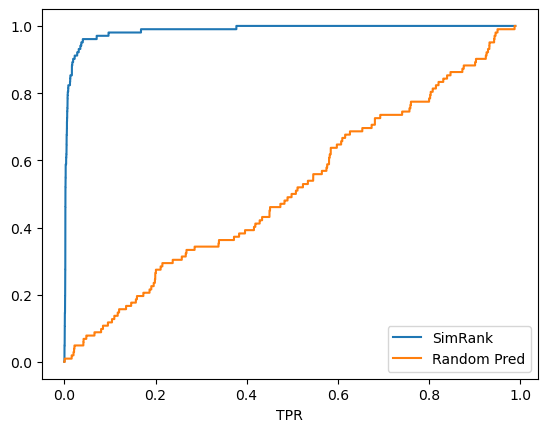

In [63]:
plt.plot(simrank_evaluation.fallout(), simrank_evaluation.recall(), label="SimRank")
plt.plot(rnd_evaluation.fallout(), rnd_evaluation.recall(), label="Random Pred")

plt.xlabel("FPR")
plt.xlabel("TPR")
plt.legend()
plt.show()

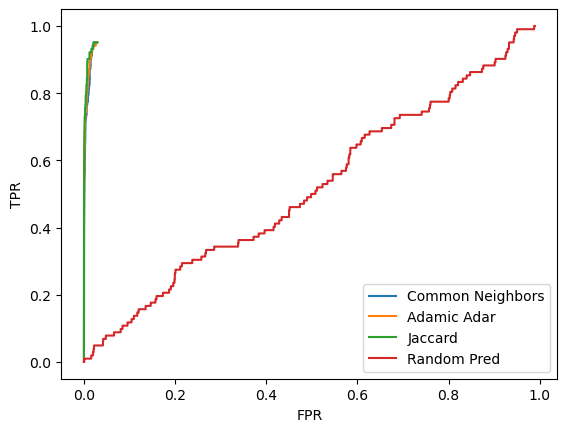

In [64]:
plt.plot(cn_evaluation.fallout(), cn_evaluation.recall(), label="Common Neighbors")
plt.plot(aa_evaluation.fallout(), aa_evaluation.recall(), label="Adamic Adar")
plt.plot(jc_evaluation.fallout(), jc_evaluation.recall(), label="Jaccard")
plt.plot(rnd_evaluation.fallout(), rnd_evaluation.recall(), label="Random Pred")


plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

In [66]:
preds = list(nx.preferential_attachment(training,universe))
pref_results=[]
for u, v, p in preds:
    pref_results.append([u,v,p])
pref_results=sorted(pref_results,key=lambda x: x[2],reverse=True)
pref_results

[['KASHINO TOSHIO', 'IKEDA MASAMI', 3339],
 ['SUGAMA SADAYUKI', 'IKEDA MASAMI', 3276],
 ['ISHINAGA HIROYUKI', 'IKEDA MASAMI', 2772],
 ['SUGAMA SADAYUKI', 'KASHINO TOSHIO', 2756],
 ['MASUDA KAZUAKI', 'IKEDA MASAMI', 2646],
 ['IKEDA MASAMI', 'ABE TSUTOMU', 2646],
 ['SUGITANI HIROSHI', 'IKEDA MASAMI', 2646],
 ['KUWABARA NOBUYUKI', 'IKEDA MASAMI', 2583],
 ['IKEDA MASAMI', 'HIRABAYASHI HIROMITSU', 2457],
 ['TAJIKA HIROSHI', 'IKEDA MASAMI', 2394],
 ['KASHINO TOSHIO', 'ISHINAGA HIROYUKI', 2332],
 ['SUGAMA SADAYUKI', 'ISHINAGA HIROYUKI', 2288],
 ['MASUDA KAZUAKI', 'KASHINO TOSHIO', 2226],
 ['KASHINO TOSHIO', 'ABE TSUTOMU', 2226],
 ['SUGITANI HIROSHI', 'KASHINO TOSHIO', 2226],
 ['SUGITANI HIROSHI', 'SUGAMA SADAYUKI', 2184],
 ['SUGAMA SADAYUKI', 'ABE TSUTOMU', 2184],
 ['SUGAMA SADAYUKI', 'MASUDA KAZUAKI', 2184],
 ['KUWABARA NOBUYUKI', 'KASHINO TOSHIO', 2173],
 ['SUGIMOTO HITOSHI', 'IKEDA MASAMI', 2142],
 ['SUGAMA SADAYUKI', 'KUWABARA NOBUYUKI', 2132],
 ['IKEDA MASAMI', 'AKIYAMA YUJI', 2079],
 ['

In [67]:
def intersect(result_1, result_2, dim, name):
    print(f"{name}")
    int_1_2=[]
    count=0
    for item_1 in result_1:
        for item_2 in result_2:
            if item_1[0]==item_2[0]:
                int_1_2.append(item_1[0])
                count+=1
    print(set(int_1_2))
    return int_1_2

In [68]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

In [69]:
aa_cn = intersect(aa_results, cn_results, 300, "AA vs CN")
aa_jc = intersect(aa_results, jc_results, 300, "AA vs JC")
aa_aa = intersect(aa_results, aa_results, 300, "AA vs AA")
aa_sm = intersect(aa_results, simrank_results, 300, "AA vs SM")

AA vs CN
{'DORIS BRUCE B', 'KWATRA SHIKHAR', 'ORIKASA TSUYOSHI', 'YAMAMOTO HAJIME', 'LJUNG RICKARD', 'KAWADE HISAAKI', 'OKUYAMA TOSHIAKI', 'TERAI HARUHIKO', 'KURABAYASHI YUTAKA', 'TAJIMA FUMIO', 'YANG KYEONG-CHEOL', 'KANAI MASAHIRO', 'OGAWA YOSHIHIRO', 'OWASHI HITOAKI', 'NOBUE TOMOTAKA', 'YEO JEONGHO', 'ZHENG XIAOQING', 'YONEMITSU JUN', 'TANEYA YOICHI', 'OTSUKA NAOJI', 'SUZUKI HIROSHI', 'NOWAK EDWARD J', 'VAN DER VELDE HIMKE', 'KAWASAKI OSAMU', 'TOBIN JAMES ROBERT', 'KENMOKU TAKASHI', 'MARTIN BRIAN ALEXANDER', 'YOSHIDA ISAMU', 'BEDELL STEPHEN W', 'LEE KOOK-HEUI', 'KISHORE KUNA VENKAT SATYA RAMA', 'KANG HYUN-JEONG', 'YAMAMOTO MASAYUKI', 'TAKAHASHI WATARU', 'HORAK DAVID V', 'YANG HAI', 'KASAMOTO MASAMI', 'KASAHARA SHUNICHI', 'MATSUDA HIROSHI', 'SATO HIROSHI', 'TAKAHASHI KOJI', 'HASZ WAYNE CHARLES', 'NAM YOUNG-HAN', 'MYERS GEOFFREY DAVID', 'MASUDA KAZUAKI', 'JOO PAN-YUH', 'NIWA TAKASHI', 'SETLUR ANANT ACHYUT', 'KAWAMURA HIROYUKI', 'SHOJI MAMORU', 'KANEDA AIZO', 'KUBOTA MASAHIKO', 'IWAMURA

In [70]:
cn_jc = intersect(cn_results, jc_results, 300, "CN vs JC")
cn_aa = intersect(cn_results, aa_results, 300, "CN vs AA")
cn_sm = intersect(cn_results, simrank_results, 300, "CN vs SM")

CN vs JC
{'DORIS BRUCE B', 'KWATRA SHIKHAR', 'ORIKASA TSUYOSHI', 'YAMAMOTO HAJIME', 'LJUNG RICKARD', 'KAWADE HISAAKI', 'OKUYAMA TOSHIAKI', 'TERAI HARUHIKO', 'KURABAYASHI YUTAKA', 'TAJIMA FUMIO', 'YANG KYEONG-CHEOL', 'KANAI MASAHIRO', 'OGAWA YOSHIHIRO', 'OWASHI HITOAKI', 'NOBUE TOMOTAKA', 'YEO JEONGHO', 'ZHENG XIAOQING', 'YONEMITSU JUN', 'TANEYA YOICHI', 'OTSUKA NAOJI', 'SUZUKI HIROSHI', 'NOWAK EDWARD J', 'VAN DER VELDE HIMKE', 'KAWASAKI OSAMU', 'TOBIN JAMES ROBERT', 'KENMOKU TAKASHI', 'MARTIN BRIAN ALEXANDER', 'YOSHIDA ISAMU', 'BEDELL STEPHEN W', 'LEE KOOK-HEUI', 'KISHORE KUNA VENKAT SATYA RAMA', 'KANG HYUN-JEONG', 'YAMAMOTO MASAYUKI', 'TAKAHASHI WATARU', 'HORAK DAVID V', 'YANG HAI', 'KASAMOTO MASAMI', 'KASAHARA SHUNICHI', 'MATSUDA HIROSHI', 'SATO HIROSHI', 'TAKAHASHI KOJI', 'HASZ WAYNE CHARLES', 'NAM YOUNG-HAN', 'MYERS GEOFFREY DAVID', 'MASUDA KAZUAKI', 'JOO PAN-YUH', 'NIWA TAKASHI', 'SETLUR ANANT ACHYUT', 'KAWAMURA HIROYUKI', 'SHOJI MAMORU', 'KANEDA AIZO', 'KUBOTA MASAHIKO', 'IWAMURA

In [71]:
jc_aa = intersect(jc_results, aa_results, 300, "JC vs AA")
jc_sm = intersect(jc_results, simrank_results, 300, "JC vs SM")

JC vs AA
{'DORIS BRUCE B', 'KWATRA SHIKHAR', 'ORIKASA TSUYOSHI', 'YAMAMOTO HAJIME', 'LJUNG RICKARD', 'KAWADE HISAAKI', 'OKUYAMA TOSHIAKI', 'TERAI HARUHIKO', 'KURABAYASHI YUTAKA', 'TAJIMA FUMIO', 'YANG KYEONG-CHEOL', 'KANAI MASAHIRO', 'OGAWA YOSHIHIRO', 'OWASHI HITOAKI', 'NOBUE TOMOTAKA', 'YEO JEONGHO', 'ZHENG XIAOQING', 'YONEMITSU JUN', 'TANEYA YOICHI', 'OTSUKA NAOJI', 'SUZUKI HIROSHI', 'NOWAK EDWARD J', 'VAN DER VELDE HIMKE', 'KAWASAKI OSAMU', 'TOBIN JAMES ROBERT', 'KENMOKU TAKASHI', 'MARTIN BRIAN ALEXANDER', 'YOSHIDA ISAMU', 'BEDELL STEPHEN W', 'LEE KOOK-HEUI', 'KISHORE KUNA VENKAT SATYA RAMA', 'KANG HYUN-JEONG', 'YAMAMOTO MASAYUKI', 'TAKAHASHI WATARU', 'HORAK DAVID V', 'YANG HAI', 'KASAMOTO MASAMI', 'KASAHARA SHUNICHI', 'MATSUDA HIROSHI', 'SATO HIROSHI', 'TAKAHASHI KOJI', 'HASZ WAYNE CHARLES', 'NAM YOUNG-HAN', 'MYERS GEOFFREY DAVID', 'MASUDA KAZUAKI', 'JOO PAN-YUH', 'NIWA TAKASHI', 'SETLUR ANANT ACHYUT', 'KAWAMURA HIROYUKI', 'SHOJI MAMORU', 'KANEDA AIZO', 'KUBOTA MASAHIKO', 'IWAMURA

In [72]:

aa_sm = intersect(aa_results, simrank_results, 300, "AA vs SM")

AA vs SM
{'DORIS BRUCE B', 'KWATRA SHIKHAR', 'ORIKASA TSUYOSHI', 'YAMAMOTO HAJIME', 'LJUNG RICKARD', 'KAWADE HISAAKI', 'OKUYAMA TOSHIAKI', 'TERAI HARUHIKO', 'KURABAYASHI YUTAKA', 'TAJIMA FUMIO', 'YANG KYEONG-CHEOL', 'KANAI MASAHIRO', 'OGAWA YOSHIHIRO', 'OWASHI HITOAKI', 'NOBUE TOMOTAKA', 'YEO JEONGHO', 'ZHENG XIAOQING', 'YONEMITSU JUN', 'TANEYA YOICHI', 'OTSUKA NAOJI', 'SUZUKI HIROSHI', 'NOWAK EDWARD J', 'VAN DER VELDE HIMKE', 'KAWASAKI OSAMU', 'TOBIN JAMES ROBERT', 'KENMOKU TAKASHI', 'MARTIN BRIAN ALEXANDER', 'YOSHIDA ISAMU', 'BEDELL STEPHEN W', 'LEE KOOK-HEUI', 'KISHORE KUNA VENKAT SATYA RAMA', 'KANG HYUN-JEONG', 'YAMAMOTO MASAYUKI', 'TAKAHASHI WATARU', 'HORAK DAVID V', 'YANG HAI', 'KASAMOTO MASAMI', 'KASAHARA SHUNICHI', 'MATSUDA HIROSHI', 'SATO HIROSHI', 'TAKAHASHI KOJI', 'HASZ WAYNE CHARLES', 'NAM YOUNG-HAN', 'MYERS GEOFFREY DAVID', 'MASUDA KAZUAKI', 'JOO PAN-YUH', 'NIWA TAKASHI', 'SETLUR ANANT ACHYUT', 'KAWAMURA HIROYUKI', 'SHOJI MAMORU', 'KANEDA AIZO', 'KUBOTA MASAHIKO', 'IWAMURA

In [73]:
# All intersection
int_m=intersection(cn_jc,aa_sm)
int_final=intersection(int_m,aa_sm)

In [74]:
len(int_final)

389006

In [75]:
set(int_final)

{'ANDO TAKASHI',
 'AOTA KINYA',
 'ARA YOJI',
 'ARAI ATSUSHI',
 'ARASHIMA TERUO',
 'ASUKAI MASAMICHI',
 'ATAGO TAKESHI',
 'AZUHATA SHIGERU',
 'BAE TAEHAN',
 'BASKER VEERARAGHAVAN S',
 'BAUGHMAN AARON K',
 'BEDELL STEPHEN W',
 'BEKKI TOSHIHIKO',
 'BOARDMAN GREGORY ALLEN',
 'BODEN EUGENE PAULING',
 'BOSS GREGORY J',
 'BRAY JAMES WILLIAM',
 'BREEZE-STRINGFELLOW ANDREW',
 'BUNKER RONALD SCOTT',
 'BURDGICK STEVEN SEBASTIAN',
 'CARTER WILLIAM THOMAS',
 'CELLA JAMES ANTHONY',
 'CHAN DAVID SO KEUNG',
 'CHAN KWOK PONG',
 'CHANG YOUNG-BIN',
 'CHEN WEI',
 'CHENG KANGGUO',
 'CHIDAMBARRAO DURESETI',
 'CHILA RONALD JAMES',
 'CHO JAE-WEON',
 'CHO JOON YOUNG',
 'CHO JOON-YOUNG',
 'CHOI BYEONG-DOO',
 'CHOI HO-KYU',
 'CHOI SEUNG-HOON',
 'CHOI SEUNGHOON',
 'CHOI SUNG-HO',
 'CLEMENTS JEFFREY DONALD',
 'CLEVENGER LAWRENCE A',
 'COLBURN MATTHEW E',
 'COMANZO HOLLY ANN',
 'COOPER JARED KLINEMAN',
 'CUI YAN',
 'DALTON TIMOTHY J',
 'DAROLIA RAMGOPAL',
 'DAUM WOLFGANG',
 'DAVIS GARY CHARLES',
 'DAVIS JR LEWIS BE

### Supervised approach*

In [93]:
from stellargraph.data import EdgeSplitter

# Creazione di uno splitter per il set di test
edge_splitter_test = EdgeSplitter(g)

# Suddivisione del grafo in set di test
graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(p=0.1, method="global")

# Creazione di uno splitter per il set di addestramento
edge_splitter_train = EdgeSplitter(graph_test)

# Suddivisione del set di addestramento in esempi di addestramento e selezione del modello
graph_train, examples_train, labels_train = edge_splitter_train.train_test_split(p=0.1, method="global")

# Suddivisione ulteriore del set di addestramento in esempi di addestramento e selezione del modello
examples_train, examples_model_selection, labels_train, labels_model_selection = train_test_split(
    examples_train, labels_train, train_size=0.75, test_size=0.25
)

# Stampa delle lunghezze degli insiemi
print(len(examples_test))
print(len(examples_train))


** Sampled 4572 positive and 4572 negative edges. **
** Sampled 4115 positive and 4115 negative edges. **
9144
6172


In [94]:
pd.DataFrame(
    [
        (
            "Training Set",
            len(examples_train),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(examples_model_selection),
            "Train Graph",
            "Test Graph",
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(examples_test),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")

,Number of Examples,Hidden from,Picked from,Use
Split,,,,
Training Set,6172,Train Graph,Test Graph,Train the Link Classifier
Model Selection,2058,Train Graph,Test Graph,Select the best Link Classifier model
Test set,9144,Test Graph,Full Graph,Evaluate the best Link Classifier


In [95]:
!pip install node2vec==0.4.6

In [103]:
edge_splitter_test = EdgeSplitter(g)
graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(p=0.1, method="global")
edge_splitter_train = EdgeSplitter(graph_test)
graph_train, examples_train, labels_train = edge_splitter_train.train_test_split(p=0.1, method="global")
node2vec = Node2Vec(graph_train)
model = node2vec.fit()
edges_embs_train = HadamardEmbedder(keyed_vectors=model.wv)
train_embeddings = [edges_embs_train[str(x[0]), str(x[1])] for x in examples_train]
edges_embs_test = HadamardEmbedder(keyed_vectors=model.wv)
test_embeddings = [edges_embs_test[str(x[0]), str(x[1])] for x in examples_test]


** Sampled 4572 positive and 4572 negative edges. **
** Sampled 4115 positive and 4115 negative edges. **


Computing transition probabilities:   0%|          | 0/13237 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:41<00:00,  4.19s/it]


In [104]:
len(labels_test)

9144

### Random Forest

In [105]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split


In [106]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [107]:
clf = RandomForestClassifier(random_state = 42)

In [108]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [109]:
param_grid = { 
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 15, 20],
    'criterion': ['gini', 'entropy']
}
grid_search = GridSearchCV(clf, param_grid=param_grid, scoring='accuracy')
grid_search.fit(train_embeddings, labels_train)

C:\Users\Alma\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Alma\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Alma\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\Alma\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_param

GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200]},
             scoring='accuracy')

In [110]:
res = grid_search.cv_results_
report(res, n_top=3)

Model with rank: 1
Mean validation score: 0.947 (std: 0.002)
Parameters: {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 200}

Model with rank: 2
Mean validation score: 0.947 (std: 0.002)
Parameters: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'log2', 'n_estimators': 200}

Model with rank: 3
Mean validation score: 0.947 (std: 0.004)
Parameters: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'log2', 'n_estimators': 100}


In [111]:
rf = RandomForestClassifier(n_estimators=200, criterion = "entropy", max_depth = 20) 
rf.fit(train_embeddings, labels_train); 
 
y_pred = rf.predict(test_embeddings) 
print('Accuracy', metrics.accuracy_score(labels_test, y_pred)) 
print('Precision:', metrics.precision_score(labels_test, y_pred)) 
print('Recall:', metrics.recall_score(labels_test, y_pred)) 
print('F1-Score:', metrics.f1_score(labels_test, y_pred))

Accuracy 0.9478346456692913
Precision: 0.9738486461467253
Recall: 0.9203849518810149
F1-Score: 0.9463623074328125


In [112]:
print( classification_report(labels_test, y_pred) )

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      4572
           1       0.97      0.92      0.95      4572

    accuracy                           0.95      9144
   macro avg       0.95      0.95      0.95      9144
weighted avg       0.95      0.95      0.95      9144


In [113]:
y_score = rf.predict_proba(test_embeddings)

In [114]:
fpr, tpr, th = roc_curve(labels_test, y_score[:,1])

roc_auc = auc(fpr, tpr)
print(roc_auc)

0.9901969719062894


### Logistic Regression

In [116]:
from sklearn.linear_model import LogisticRegressionCV

In [117]:
lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="accuracy")
lr_clf.fit(train_embeddings, labels_train); 

In [118]:
y_pred_lr = lr_clf.predict(test_embeddings) 
print('Accuracy', metrics.accuracy_score(labels_test, y_pred_lr)) 
print('Precision:', metrics.precision_score(labels_test, y_pred_lr)) 
print('Recall:', metrics.recall_score(labels_test, y_pred_lr)) 
print('F1-Score:', metrics.f1_score(labels_test, y_pred_lr)) 

Accuracy 0.9492563429571304
Precision: 0.9830667920978363
Recall: 0.9142607174103237
F1-Score: 0.9474161378059837


In [119]:
print(classification_report(labels_test, y_pred_lr) )

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      4572
           1       0.98      0.91      0.95      4572

    accuracy                           0.95      9144
   macro avg       0.95      0.95      0.95      9144
weighted avg       0.95      0.95      0.95      9144


In [120]:
y_score_lr = lr_clf.predict_proba(test_embeddings)
fpr_lg, tpr_lg, th_lg = roc_curve(labels_test, y_score_lr[:,1])

roc_auc = auc(fpr_lg, tpr_lg)
print(roc_auc)

0.9336754151903366
